# **P9.1 - Project 1: Customer Sentiment Analysis for Market Expansion**

## **Business Scenario**

Your company is planning to expand into a new product category. As a data analyst, you've been hired to analyze customer reviews from Amazon to understand:

1. **Customer Pain Points**: What frustrates customers about products in this category?
2. **Positive Attributes**: What do customers love about these products?
3. **Temporal Trends**: How have sentiments and issues evolved over time?
4. **Product Quality Patterns**: What distinguishes highly-rated products from poorly-rated ones?
5. **Market Opportunities**: What gaps or opportunities exist in the market?

---

## **Your Task**

Choose **ONE** of the following product categories to analyze:

- Apparel
- Automotive
- Baby
- Beauty
- Books
- Camera
- Digital Ebook Purchase
- Electronics
- Furniture
- Grocery
- Health Personal Care
- Major Appliances
- Office Products
- Personal Care Appliances
- Shoes
- Sports
- Tools
- Watches

**Important**: You must inform me which category you've selected before beginning your analysis.

---

## **Deliverables**

1. **Jupyter Notebook** with complete analysis following the structure below
2. **Saved insights file** (JSON format) with extracted pain points and positives
3. **Visualizations** showing key findings
4. **Executive Summary** with business recommendations

---

## **Grading Criteria**

- Data loading and exploration (10%)
- Structured LLM analysis implementation (25%)
- Use of parallel processing for efficiency (15%)
- Clustering and embedding analysis (20%)
- Temporal and comparative analysis (15%)
- Quality of visualizations and insights (10%)
- Executive summary and recommendations (5%)

---

## **Getting Started**

This notebook provides:
- Helper functions for LLM API calls (sync and async)
- Data loading templates
- Structured extraction prompts
- Parallel processing examples
- TODO sections where you need to implement analysis
- Hints pointing to relevant course materials

---

## **Part 0: Understanding Parallel Processing**

### **Why Parallel Processing?**

When analyzing thousands of reviews, calling the LLM sequentially (one after another) would take **hours**. Parallel processing allows us to process multiple reviews **simultaneously**, dramatically reducing total time.

### **Sequential vs Parallel: A Simple Analogy**

Imagine you need to send 1000 letters:

**Sequential Processing (One at a time)**:
```
Letter 1 → Post Office → Wait for confirmation → Letter 2 → Post Office → Wait...
Time: 1000 letters × 2 minutes each = 2000 minutes (33+ hours)
```

**Parallel Processing (10 workers simultaneously)**:
```
Worker 1: Letters 1-100   ┐
Worker 2: Letters 101-200 │
Worker 3: Letters 201-300 ├─ All working at the same time!
...                       │
Worker 10: Letters 901-1000┘

Time: 100 letters × 2 minutes = 200 minutes (3.3 hours)
```

**Result**: 10x faster!

---

### **How It Works in Python**

We use **asyncio** and **aiohttp** for asynchronous HTTP requests:

1. **Async Functions**: Functions that can "pause" while waiting for responses
2. **Concurrent Requests**: Send multiple API requests without waiting for each to complete
3. **Gather Results**: Collect all responses when they're ready

**Key Components**:
```python
async def process_review(review):      # 'async' keyword marks function as asynchronous
    response = await api_call(review)  # 'await' pauses THIS function (but others keep running)
    return response

# Process many reviews concurrently
tasks = [process_review(r) for r in reviews]  # Create tasks
results = await asyncio.gather(*tasks)          # Run all tasks in parallel
```

---

### **Important Considerations**

1. **API Rate Limits**: Don't send too many requests at once
   - Use `CONCURRENT_REQUESTS` to control batch size (typically 10-50)
   - Process in batches to avoid overwhelming the API

2. **Error Handling**: Some requests may fail
   - Always check if response is valid before processing
   - Consider retry logic for failed requests

3. **Progress Tracking**: Use `tqdm` to monitor progress
   - Shows how many batches completed
   - Estimates remaining time

4. **Saving Checkpoints**: For large datasets
   - Save results periodically (e.g., every 100 batches)
   - Allows recovery if process is interrupted

---

### **Example: Sequential vs Async**

**Sequential (SLOW)**:
```python
results = []
for review in reviews:  # Process one at a time
    result = process_review_sync(review)  # Wait for completion
    results.append(result)  # Then move to next
# Time: N reviews × avg_time per review
```

**Parallel (FAST)**:
```python
async def process_batch(reviews_batch):
    tasks = [process_review_async(r) for r in reviews_batch]  # Create all tasks
    return await asyncio.gather(*tasks)  # Run simultaneously!

# Process in batches of 10
for i in range(0, len(reviews), 10):
    batch = reviews[i:i+10]
    batch_results = await process_batch(batch)
    results.extend(batch_results)
# Time: (N reviews / batch_size) × avg_time per review
```

---

### **Real Performance Example**

Processing 5,000 reviews:
- Sequential: ~2 seconds/review = **10,000 seconds (2.8 hours)**
- Parallel (20 concurrent): ~2 seconds/batch of 20 = **500 seconds (8 minutes)**

**20x faster!**

---

## **Part 1: Setup and Data Loading**

### **TODO 1.1**: Import required libraries

**Hints**:
- Reference: M8.1 (imports section)
- You'll need: pandas, numpy, json, pathlib, tqdm, asyncio, aiohttp, openai, FlagEmbedding, sklearn, plotly, matplotlib, seaborn
- Don't forget `from dotenv import load_dotenv`

In [3]:
# Core Libraries
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
from typing import List, Dict, Any
from tqdm.auto import tqdm
import asyncio
import aiohttp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML and Embeddings
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from FlagEmbedding import BGEM3FlagModel

# LLM API
import openai
from dotenv import load_dotenv

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load environment variables
load_dotenv()

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


### **TODO 1.2**: Configure constants

**Update the following**:
1. `DATA_FILE`: Change to your selected category file
2. `LLM_MODEL`: Choose an appropriate model from OpenRouter
3. `CONCURRENT_REQUESTS`: Start with 10, adjust based on API rate limits

In [4]:
# ========================================
# MODIFY THESE CONSTANTS FOR YOUR PROJECT
# ========================================

# TODO: Change this to your selected category file
DATA_FILE = "amazon_reviews_us_Furniture_v1_00_filtered.tsv"

# TODO: Choose your LLM model (reference: M8.1)
LLM_MODEL = "google/gemini-2.5-flash-lite-preview-09-2025"  # Example: fast and free
# Other options:
# - "openai/gpt-4o-mini" (balanced, paid)
# - "meta-llama/llama-3.2-3b-instruct:free" (free, smaller)

# Embedding model (pre-configured, no changes needed)
EMBEDDING_MODEL = "BAAI/bge-m3"

# Parallel processing configuration
CONCURRENT_REQUESTS = 20  # Number of reviews to process simultaneously

print(f"✓ Configuration set:")
print(f"  - Data file: {DATA_FILE}")
print(f"  - LLM model: {LLM_MODEL}")
print(f"  - Concurrent requests: {CONCURRENT_REQUESTS}")

✓ Configuration set:
  - Data file: amazon_reviews_us_Furniture_v1_00_filtered.tsv
  - LLM model: google/gemini-2.5-flash-lite-preview-09-2025
  - Concurrent requests: 20


### **HELPER FUNCTION**: Load data

**This function is provided for you** - no modifications needed.

**What it does**:
1. Loads TSV file with proper error handling
2. Converts review_date to datetime
3. Extracts year and year_month for temporal analysis
4. Displays basic statistics

In [5]:
def load_review_data(filepath):
    """
    Load and preprocess Amazon review data from TSV file.

    Args:
        filepath: Path to the TSV file

    Returns:
        pandas DataFrame with loaded and preprocessed data
    """
    print(f"Loading data from: {filepath}")

    # Load TSV file
    df = pd.read_csv(filepath, sep='\t', on_bad_lines='skip', low_memory=False)

    # Convert review_date to datetime
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
    df['year'] = df['review_date'].dt.year
    df['year_month'] = df['review_date'].dt.to_period('M')

    # Display overview
    print(f"\n✓ Dataset Overview:")
    print(f"  - Total reviews: {len(df):,}")
    print(f"  - Date range: {df['review_date'].min()} to {df['review_date'].max()}")
    print(f"  - Star ratings: {df['star_rating'].min()} to {df['star_rating'].max()}")
    print(f"  - Columns: {', '.join(df.columns.tolist())}")

    return df

# Load your data
df = load_review_data(DATA_FILE)

# Display sample
print("\nSample reviews:")
df.head()

Loading data from: amazon_reviews_us_Furniture_v1_00_filtered.tsv

✓ Dataset Overview:
  - Total reviews: 89,464
  - Date range: 2008-01-01 00:00:00 to 2015-08-31 00:00:00
  - Star ratings: 1 to 5
  - Columns: marketplace, customer_id, review_id, product_id, product_parent, product_title, product_category, star_rating, helpful_votes, total_votes, vine, verified_purchase, review_headline, review_body, review_date, year, year_month

Sample reviews:


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,year_month
0,US,12930719,R30QDKV3ZHK6JI,B001A0AXBU,550484501,Black 2 x 9 Chenille runner,Furniture,2,1,1,N,Y,not what I expected,The product quality was OK but is nowhere near...,2008-12-31,2008,2008-12
1,US,36306781,R1X58BUU49VQWL,B000VNUH2W,76658424,Executive Comfort Chair with Top Grain Burgund...,Furniture,1,0,0,N,N,bad quality,had the chair for one week and arm showS disco...,2008-12-31,2008,2008-12
2,US,47891556,R2UXYJ3U0YH4ST,B001FOYFBA,443854803,Westinghouse Set Of 2 Outdoor Wireless Remote ...,Furniture,1,0,0,N,N,DOA,Found the item at Target for 75% off. Got it ...,2008-12-31,2008,2008-12
3,US,51018163,R1OH3T3618EIEL,B000HKVUFW,42684042,Alex Toys Deluxe Pottery Wheel,Furniture,1,2,2,N,N,more clay molding than a pottery wheel,"We received this as a gift, the idea is amazin...",2008-12-31,2008,2008-12
4,US,33378005,R1F4LFSPRC7UCN,B001I5HTIW,59054268,Vickerman Co. 7.5' Prelit Flocked Alaskan Arti...,Furniture,5,0,0,N,N,christmas tree,I love this tree. I lost mine in a tornado. I ...,2008-12-31,2008,2008-12


---

## **Part 2: Initialize LLM and Embedding Models**

### **HELPER FUNCTIONS**: API client setup

**These functions are provided for you** - no modifications needed.

**Reference**: M8.1 (Agent Planner setup)

In [6]:
def setup_llm_client():
    """
    Initialize OpenRouter API client.
    Requires OPENROUTER_API_KEY environment variable.
    """
    api_key = os.environ.get("OPENROUTER_API_KEY")
    if not api_key:
        raise ValueError(
            "OPENROUTER_API_KEY not found in environment variables.\n"
            "Please create a .env file with: OPENROUTER_API_KEY=your_key_here"
        )
    return openai.OpenAI(base_url='https://openrouter.ai/api/v1', api_key=api_key)

# Initialize LLM client
llm_client = setup_llm_client()
print("✓ LLM client initialized!")

✓ LLM client initialized!


In [7]:
def initialize_embedder(model_name=EMBEDDING_MODEL):
    """
    Initialize the embedding model (BGE-M3).
    Uses GPU if available, otherwise CPU.

    Reference: M7.1 (embedding initialization)
    """
    import torch

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    embedder = BGEM3FlagModel(model_name, use_fp16=(device == "cuda"))
    print(f"✓ Embedding model '{model_name}' initialized!")

    return embedder

# Initialize embedding model
embedder = initialize_embedder()

Using device: cpu


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

✓ Embedding model 'BAAI/bge-m3' initialized!


### **HELPER FUNCTIONS**: LLM message sending (sync and async)

**These functions are provided for you** - no modifications needed.

**Two versions**:
1. `send_message()`: Synchronous (blocking) - use for single calls or testing
2. `send_message_async()`: Asynchronous (non-blocking) - use for parallel processing

**Reference**: M8.1 (LLM helper functions)

In [20]:
def send_message(messages, model=LLM_MODEL, max_tokens=2000, temperature=0.1, response_format=None):
    """
    Send a synchronous message to the LLM.
    Use this for single API calls or testing.

    Args:
        messages: List of message dicts with 'role' and 'content'
        model: Model identifier
        max_tokens: Maximum response length
        temperature: Creativity (0.0-1.0, lower = more deterministic)
        response_format: Optional dict specifying format (e.g., {"type": "json_object"})

    Returns:
        String response or None if error
    """
    try:
        completion_params = {
            "model": model,
            "messages": messages,
            "max_tokens": max_tokens,
            "temperature": temperature
        }
        if response_format:
            completion_params["response_format"] = response_format

        response = llm_client.chat.completions.create(**completion_params)

        if response and response.choices and len(response.choices) > 0:
            if response.choices[0].message and response.choices[0].message.content:
                return response.choices[0].message.content.strip()
        return None
    except Exception as e:
        print(f"Error calling LLM: {e}")
        return None


async def send_message_async(session, messages, model=LLM_MODEL, max_tokens=2000, temperature=0.1, response_format=None):
    """
    Send an asynchronous message to the LLM.
    Use this for parallel processing of multiple reviews.

    Args:
        session: aiohttp.ClientSession instance
        messages: List of message dicts
        model: Model identifier
        max_tokens: Maximum response length
        temperature: Creativity setting
        response_format: Optional format specification

    Returns:
        String response or None if error
    """
    api_key = os.environ.get("OPENROUTER_API_KEY")
    url = "https://openrouter.ai/api/v1/chat/completions"

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature
    }

    if response_format:
        payload["response_format"] = response_format

    try:
        async with session.post(url, json=payload, headers=headers) as response:
            if response.status == 200:
                data = await response.json()
                if data.get("choices") and len(data["choices"]) > 0:
                    return data["choices"][0]["message"]["content"].strip()
            else:
                error_text = await response.text()
                print(f"API Error {response.status}: {error_text}")
                return None
    except Exception as e:
        print(f"Error in async LLM call: {e}")
        return None

print("✓ Helper functions defined (sync and async)!")

✓ Helper functions defined (sync and async)!


---

## **Part 3: Exploratory Data Analysis**

### **TODO 3.1**: Create visualizations

**Your task**: Create the following visualizations to understand your data:

1. **Rating Distribution**: Bar chart showing how many reviews for each star rating
2. **Ratings Over Time**: Line chart showing average rating by month/year
3. **Review Volume Over Time**: Line chart showing number of reviews by month/year

**Hints**:
- Use `plotly.graph_objects` or `plotly.express` for interactive plots
- Reference: M9.1 Example (Part 3)
- For temporal aggregation, use `df.groupby('year_month')` or `df.groupby('year')`

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---- ensure star_rating is numeric ----
df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce')

# ---- build rating summary ----
rating_counts = (
    df.groupby('star_rating')
      .size()
      .reset_index(name='review_count')
      .sort_values('star_rating')
)

# ---- title and output directory ----
title = "Rating Distribution for Furniture Reviews"
output_dir = "furniture_insight_charts"   # same dir as before
os.makedirs(output_dir, exist_ok=True)

# ---- sanitize filename ----
file_name = f"{title.lower().replace(' ', '_')}.png"
output_path = os.path.join(output_dir, file_name)

# ---- create visualization ----
plt.figure(figsize=(8, 5))
bars = plt.bar(
    rating_counts['star_rating'].astype(str),
    rating_counts['review_count'],
    color="#4472C4"
)

# ---- add titles and labels ----
plt.title(title)
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")

# ---- annotate each bar with value ----
for bar, value in zip(bars, rating_counts['review_count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(value),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()

# ---- save high-resolution png ----
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Saved {output_path}")


✓ Saved furniture_insight_charts/rating_distribution_for_furniture_reviews.png


In [ ]:

import matplotlib.dates as mdates

# ---- Prepare data ----
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['year_month'] = df['review_date'].dt.to_period('M')

avg_rating_time = (
    df.groupby('year_month')['star_rating']
      .mean()
      .reset_index()
      .sort_values('year_month')
)

# Convert Period to Timestamp for continuous x-axis
avg_rating_time['year_month_dt'] = avg_rating_time['year_month'].dt.to_timestamp()

# ---- Title and output path ----
title = "Average Rating Over Time"
output_dir = "furniture_insight_charts"
os.makedirs(output_dir, exist_ok=True)

file_name = f"{title.lower().replace(' ', '_')}.png"
output_path = os.path.join(output_dir, file_name)

# ---- Create line chart ----
plt.figure(figsize=(10, 5))
plt.plot(
    avg_rating_time['year_month_dt'],
    avg_rating_time['star_rating'],
    marker='o',
    linestyle='-',
    color='#2E86C1'
)

# ---- Labels and title ----
plt.title(title)
plt.xlabel("Year-Month (Quarterly)")
plt.ylabel("Average Star Rating")

# ---- Format x-axis to show one tick per quarter ----
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))     # every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))     # format YYYY-MM

plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# ---- Save high-resolution PNG ----
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Saved {output_path}")


✓ Saved furniture_insight_charts/average_rating_over_time.png


In [24]:
import matplotlib.dates as mdates


# ---- Prepare data ----
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['year_month'] = df['review_date'].dt.to_period('M')

review_volume = (
    df.groupby('year_month')
      .size()
      .reset_index(name='num_reviews')
      .sort_values('year_month')
)

# Convert Period to Timestamp for chronological plotting
review_volume['year_month_dt'] = review_volume['year_month'].dt.to_timestamp()

# ---- Title and output directory ----
title = "Review Volume Over Time"
output_dir = "furniture_insight_charts"
os.makedirs(output_dir, exist_ok=True)

# ---- Sanitize filename ----
file_name = f"{title.lower().replace(' ', '_')}.png"
output_path = os.path.join(output_dir, file_name)

# ---- Create line chart ----
plt.figure(figsize=(10, 5))
plt.plot(
    review_volume['year_month_dt'],
    review_volume['num_reviews'],
    marker='o',
    linestyle='-',
    color='#117A65'
)

# ---- Labels and title ----
plt.title(title)
plt.xlabel("Year-Month (Quarterly)")
plt.ylabel("Number of Reviews")

# ---- Format x-axis to show one tick per quarter ----
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))   # quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# ---- Save high-resolution PNG ----
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Saved {output_path}")


✓ Saved furniture_insight_charts/review_volume_over_time.png


### **TODO 3.2**: Identify top and bottom products

**Your task**:
1. Group reviews by `product_title`
2. Calculate average rating and review count for each product
3. Filter to products with at least 10 reviews
4. Identify top 10 highest-rated and bottom 10 lowest-rated products

**Hints**:
- Use `df.groupby('product_title').agg({...})`
- Use `.nlargest()` and `.nsmallest()`
- Reference: M9.1 Example (Part 3)

In [25]:
import pandas as pd

# 1️⃣ Group reviews by product_title and compute both average rating & review count
product_stats = (
    df.groupby('product_title')
      .agg(avg_rating=('star_rating', 'mean'),
           review_count=('star_rating', 'count'))
      .reset_index()
)

# 2️⃣ Filter only products with at least 10 reviews
filtered_products = product_stats[product_stats['review_count'] >= 10]

# 3️⃣ Top 10 highest-rated products
top10_products = filtered_products.nlargest(10, 'avg_rating')

# 4️⃣ Bottom 10 lowest-rated products
bottom10_products = filtered_products.nsmallest(10, 'avg_rating')

# Display
print("Top 10 Highest-Rated Products:")
display(top10_products)

print("\nBottom 10 Lowest-Rated Products:")
display(bottom10_products)


Top 10 Highest-Rated Products:


,product_title,avg_rating,review_count
347,1062 Red White Black Area Rug Abstract Carpet,5.000000,12
1321,4 Pack Beige Metal Folding Chairs,5.000000,10
11371,Espresso Kids Chair Seat Childrens Brown Leath...,5.000000,11
14442,Herman Miller Caster Set for Classic Aeron Cha...,5.000000,10
15485,"Honey-Can-Do SHF-01939 4-Inch Caster Wheels, 3...",5.000000,12
17175,Knape & Vogt 1388 Full-Extension Heavy-Duty TV...,5.000000,13
21180,Noble House Home Accents Buchanan Bench,5.000000,10
11808,Fashion Bed Group Doral Bed,4.950000,20
10022,Designs2Go XL Two Tier Swivel TV Stand,4.941176,17
2828,"Alera Complete Wire Shelving Unit with Caster,...",4.928571,14



Bottom 10 Lowest-Rated Products:


,product_title,avg_rating,review_count
9760,Dead Dog Prop,1.200000,20
17362,LG 45 Pint Dehumidifier with Electronic Contro...,1.666667,12
26492,Sharp SPC890 Quartz Analog Atomic Wall Clock S...,1.666667,12
30130,"Tvilum Portland 5-Drawer Dresser, Coffee",1.750000,12
31771,"Winsome Wood Adjustable Laptop Cart/Table, Ant...",1.904762,21
7604,Classic Brands Wooden Bed Slats Bunkie Board F...,2.000000,11
24565,Rug Grippers Set Of 4,2.000000,11
24574,Ruggies Rug Grippers - 8 CT,2.046512,43
20447,My Best Fish Friend BFF As Seen On TV,2.100000,10
12422,Floral Design Cream Colored Padded Vanity Foot...,2.133333,15


---

## **Part 4: Structured LLM Analysis**

### **Understanding the Extraction Process**

We'll use the LLM to extract structured insights from each review:

**Input**: Raw review text
```
"This game is amazing! Graphics are stunning and gameplay is smooth.
Only issue is occasional lag during multiplayer."
```

**Output**: Structured JSON
```json
{
  "pain_points": ["multiplayer lag"],
  "positive_aspects": ["stunning graphics", "smooth gameplay"],
  "main_themes": ["game quality", "performance"],
  "sentiment": "positive"
}
```

**Why 2-3 words maximum?**
- Enables aggregation across reviews
- "download was very slow" → "slow download"
- "took forever to install" → "slow installation"
- Both can be grouped as similar issues

---

### **HELPER FUNCTION**: Extract review insights (async)

**This function is provided for you** - but you should understand how it works.

**Key components**:
1. **Prompt engineering**: Clear instructions for structured output
2. **JSON mode**: Ensures LLM returns valid JSON
3. **Error handling**: Gracefully handles invalid responses
4. **Metadata**: Attaches review context to results

In [ ]:
async def extract_review_insights_async(session, review_text, rating, product_title, review_id, year):
    """
    Extract structured insights from a review using LLM (async version for parallel processing).

    Args:
        session: aiohttp.ClientSession
        review_text: The review text to analyze
        rating: Star rating (1-5)
        product_title: Product name
        review_id: Unique review identifier
        year: Review year for temporal analysis

    Returns:
        Dict with extracted insights or None if error
    """
    prompt = f"""You are analyzing a customer review for a product.

Product: {product_title}
Rating: {rating}/5 stars
Review: {review_text}

Extract the following information in JSON format. IMPORTANT: Use ONLY 2-3 words maximum for each item in the lists to enable aggregation across reviews.

{{
  "pain_points": ["2-3 word descriptions of problems, e.g. 'download issues', 'poor quality', 'breaks easily'"],
  "positive_aspects": ["2-3 word descriptions of positives, e.g. 'great quality', 'fast shipping', 'good value'"],
  "main_themes": ["2-3 word topics, e.g. 'product quality', 'customer service', 'durability'"],
  "sentiment": "positive/negative/mixed/neutral",
  "purchase_decision_factors": ["2-3 word factors, e.g. 'price point', 'brand reputation', 'features'"]
}}

CRITICAL RULES:
- Each item in lists must be 2-3 words MAXIMUM (not full sentences)
- Use consistent, generic terminology
- Be specific but concise
- Use lowercase
- If nothing is mentioned for a category, use an empty list
"""

    messages = [{"role": "user", "content": prompt}]

    response = await send_message_async(
        session,
        messages,
        max_tokens=800,
        temperature=0.1,
        response_format={"type": "json_object"}
    )

    if response:
        try:
            insights = json.loads(response)
            # Attach metadata
            insights['review_id'] = review_id
            insights['star_rating'] = rating
            insights['year'] = year
            insights['product_title'] = product_title
            insights['review_body'] = review_text
            return insights
        except json.JSONDecodeError:
            return None
    return None

print("✓ Extraction function defined (async)!")

✓ Extraction function defined (async)!


### **TODO 4.1**: Test the extraction function

**Your task**: Test the extraction function on a single review before processing all reviews.

**Why test first?**
- Verify the prompt works correctly
- Check that JSON parsing succeeds
- Ensure output quality is acceptable
- Saves time and API costs before full processing

**Hints**:
- Select one review: `test_review = df.iloc[0]`
- For async function, you need to use `await` inside an async context
- Use `asyncio.run()` to run async code in Jupyter
- Reference: M9.1 Example (test case cell)

In [ ]:
import aiohttp
import asyncio
import json
import numpy as np  # <--- important

# pick one sample row (you can change the index, or do df.sample(1).iloc[0])
sample = df.iloc[0]

review_text = sample['review_body']
rating = sample['star_rating']
product_title = sample['product_title']
review_id = sample['review_id']
year = sample['year']

print("===== INPUT SAMPLE =====")
print(f"Product Title: {product_title}")
print(f"Rating: {rating}")
print(f"Year: {year}")
print("Review Text (first 300 chars):")
print(review_text[:300] + ("..." if len(review_text) > 300 else ""))
print("=========================\n")


def make_json_safe(obj):
    """
    Recursively convert any numpy / pandas scalar types inside obj
    into plain Python types so json.dumps won't fail.
    """
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    else:
        return obj


async def test_single_review():
    async with aiohttp.ClientSession() as session:
        result = await extract_review_insights_async(
            session,
            review_text=review_text,
            rating=rating,
            product_title=product_title,
            review_id=review_id,
            year=year
        )

        print("===== MODEL RESPONSE =====")
        if result:
            safe_result = make_json_safe(result)
            print(json.dumps(safe_result, indent=2))
        else:
            print("No response or invalid JSON.")
        print("===========================")


# In Jupyter/IPython, run:
await test_single_review()


===== INPUT SAMPLE =====
Product Title: Black 2 x 9 Chenille runner
Rating: 2
Year: 2008
Review Text (first 300 chars):
The product quality was OK but is nowhere near the full black color that is shown in the picture.  It was a black/beige checker pattern.  It was also really slippery so it would definitely need a rug pad or something similar.  The company handling the returns was very nice though.

===== MODEL RESPONSE =====
{
  "pain_points": [
    "color inaccurate",
    "slippery rug"
  ],
  "positive_aspects": [
    "return handling nice"
  ],
  "main_themes": [
    "color accuracy",
    "safety hazard",
    "customer service"
  ],
  "sentiment": "mixed",
  "purchase_decision_factors": [
    "visual appearance",
    "product safety"
  ],
  "review_id": "R30QDKV3ZHK6JI",
  "star_rating": 2,
  "year": 2008,
  "product_title": "Black 2 x 9 Chenille runner",
  "review_body": "The product quality was OK but is nowhere near the full black color that is shown in the picture.  It was a bl

### **Understanding Parallel Processing Implementation**

Now we'll process ALL reviews using parallel processing. Here's how it works:

**Step 1: Prepare Reviews**
```python
reviews_to_process = []
for review in df:
    if review_is_valid(review):
        reviews_to_process.append(review_data)
```

**Step 2: Process in Batches**
```python
batch_size = 10  # Process 10 at once
for i in range(0, len(reviews), batch_size):
    batch = reviews[i:i+batch_size]
    results = await process_batch(batch)  # All 10 run in parallel!
```

**Step 3: Handle Errors & Save Checkpoints**
```python
if batch_num % 100 == 0:  # Every 100 batches
    save_checkpoint(results)  # Save progress
```

---

### **HELPER FUNCTION**: Parallel review processing

**This function is provided for you** - it handles the complex async orchestration.

In [ ]:
async def process_reviews_batch(reviews_batch):
    """
    Process a batch of reviews concurrently.

    Args:
        reviews_batch: List of review dicts to process

    Returns:
        List of extracted insights (or None for failed extractions)
    """
    async with aiohttp.ClientSession() as session:
        tasks = []
        for review in reviews_batch:
            task = extract_review_insights_async(
                session,
                review['review_body'],
                review['star_rating'],
                review['product_title'],
                review['review_id'],
                review['year']
            )
            tasks.append(task)

        # Run all tasks in parallel and collect results
        results = await asyncio.gather(*tasks)
        return [r for r in results if r is not None]


async def process_all_reviews(reviews_list, batch_size=CONCURRENT_REQUESTS, checkpoint_interval=1000):
    """
    Process all reviews in batches with progress tracking and checkpoints.

    Args:
        reviews_list: List of all reviews to process
        batch_size: Number of reviews to process concurrently
        checkpoint_interval: Save checkpoint every N batches

    Returns:
        List of all extracted insights
    """
    all_insights = []

    # Process in batches
    for i in tqdm(range(0, len(reviews_list), batch_size), desc="Processing batches"):
        batch = reviews_list[i:i + batch_size]
        batch_results = await process_reviews_batch(batch)
        all_insights.extend(batch_results)

        # Save checkpoint periodically
        if (i // batch_size + 1) % checkpoint_interval == 0:
            temp_df = pd.DataFrame(all_insights)
            temp_df.to_json('review_insights_checkpoint.json', orient='records', indent=2)
            print(f"\n✓ Checkpoint: Saved {len(all_insights)} insights...")

    return all_insights

print("✓ Parallel processing functions defined!")

✓ Parallel processing functions defined!


### **TODO 4.2**: Process ALL reviews

**Your task**: Run the parallel processing pipeline on all reviews.

**Before running**:
1. Estimate API costs: ~0.0005 cents per review depending on model
2. Estimate time: ~5-10 minutes for 5000 reviews with batch_size=10
3. Ensure you have disk space for checkpoints

**For testing**: Start with a small subset (e.g., first 100 reviews) to verify everything works.

**Hints**:
- Filter reviews by minimum length (e.g., >20 characters)
- Limit review text length to save tokens (e.g., first 2000 characters)
- Monitor the progress bar
- Check checkpoints are being saved
- Reference: M9.1 Example (parallel processing cell)

In [ ]:
print("Preparing reviews for analysis...")

reviews_to_process = []

# TODO: Loop through df and create review dicts
# Hint: Filter by review length, limit text length
# Example structure:
for idx, row in df.iterrows():
    review_body = str(row['review_body'])[:2000]  # Limit length
    if len(review_body.strip()) >= 20:  # Minimum length filter
        reviews_to_process.append({
            'review_body': review_body,
            'star_rating': row['star_rating'],
            'product_title': row['product_title'],
            'review_id': row['review_id'],
            'year': row['year']
        })

# For testing, limit to first N reviews:
#reviews_to_process = reviews_to_process[:100]  # TESTING: Remove this for full dataset

print(f"Total reviews to process: {len(reviews_to_process)}")
print(f"Estimated API calls: {len(reviews_to_process)}")
print(f"Estimated time (batch_size={CONCURRENT_REQUESTS}): ~{len(reviews_to_process) * 2 / CONCURRENT_REQUESTS / 60:.1f} minutes")

# TODO: Run the processing
insights_list = await process_all_reviews(reviews_to_process)
print(f"\n✓ Extracted insights from {len(insights_list)} reviews")
print(f"Success rate: {len(insights_list)/len(reviews_to_process)*100:.1f}%")

print(f"Total insights returned: {len(insights_list)}")

Preparing reviews for analysis...
Total reviews to process: 87260
Estimated API calls: 87260
Estimated time (batch_size=20): ~145.4 minutes


Processing batches:   9%|▊         | 375/4363 [13:06<2:07:08,  1.91s/it]

Error in async LLM call: Server disconnected


Processing batches:  23%|██▎       | 1000/4363 [32:59<1:46:26,  1.90s/it]


✓ Checkpoint: Saved 19998 insights...


Processing batches:  32%|███▏      | 1382/4363 [45:29<1:29:23,  1.80s/it]

Error in async LLM call: Server disconnected


Processing batches:  40%|████      | 1751/4363 [57:21<1:18:35,  1.81s/it]

Error in async LLM call: Server disconnected


Processing batches:  46%|████▌     | 2000/4363 [1:04:54<1:18:01,  1.98s/it]


✓ Checkpoint: Saved 39995 insights...


Processing batches:  69%|██████▉   | 3000/4363 [1:35:09<43:16,  1.90s/it]  


✓ Checkpoint: Saved 59995 insights...


Processing batches:  73%|███████▎  | 3197/4363 [1:41:05<33:02,  1.70s/it]  

Error in async LLM call: [Errno 54] Connection reset by peer


Processing batches:  73%|███████▎  | 3198/4363 [2:25:36<259:38:12, 802.31s/it]

Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 
Error in async LLM call: 


Processing batches:  87%|████████▋ | 3795/4363 [2:43:43<16:34,  1.75s/it]     

API Error 502: <!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>

<title> | 500: Internal server error</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />
</head>
<body>
<div id="cf-wrapper">
    <div id="cf-error-details" class="p-0">
        <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-8">
            <h1 class="inline-block sm:block sm:mb-2 font-light text-60 lg:text-4xl text-black-dark leading-tig

Processing batches:  92%|█████████▏| 4000/4363 [2:51:21<11:14,  1.86s/it]


✓ Checkpoint: Saved 79974 insights...


Processing batches: 100%|██████████| 4363/4363 [3:02:30<00:00,  2.51s/it]


✓ Extracted insights from 87233 reviews
Success rate: 100.0%
Total insights returned: 87233


### **TODO 4.3**: Save and load insights

**Your task**:
1. Save the extracted insights to a JSON file
2. Load insights from the saved file (for future use)
3. Convert to pandas DataFrame for analysis

**Why save?**
- Avoid re-running expensive LLM processing
- Share results with others
- Create backups before further processing

In [ ]:

#To save the remaining insights after the last checkpoint
pd.DataFrame(insights_list).to_json('review_insights_checkpoint.json', orient='records', indent=2)
print("✓ Final checkpoint file updated with all insights.")


✓ Final checkpoint file updated with all insights.


In [7]:


insights_df = pd.read_json('review_insights_checkpoint.json', orient='records')
print(f"✓ Loaded {len(insights_df)} insights from file")

# Display sample
insights_df.head()


✓ Loaded 87233 insights from file


,pain_points,positive_aspects,main_themes,sentiment,purchase_decision_factors,review_id,star_rating,year,product_title,review_body
0,"[color inaccurate, slippery rug]",[return handling nice],"[color accuracy, product safety, customer serv...",mixed,"[visual appearance, product safety]",R30QDKV3ZHK6JI,2,2008,Black 2 x 9 Chenille runner,The product quality was OK but is nowhere near...
1,"[arm discoloration, poor durability, looks cheap]",[impressed first],"[material quality, short lifespan, low value]",negative,"[initial look, durability expectation]",R1X58BUU49VQWL,1,2008,Executive Comfort Chair with Top Grain Burgund...,had the chair for one week and arm showS disco...
2,"[not working, remote defective]",[great discount],"[product functionality, remote control]",negative,[deep discount],R2UXYJ3U0YH4ST,1,2008,Westinghouse Set Of 2 Outdoor Wireless Remote ...,Found the item at Target for 75% off. Got it ...
3,"[clay won't stick, clay flies off, messy clay]","[amazing idea, kiddo had fun]","[clay adhesion, wheel function, alternative mo...",negative,[gift received],R1OH3T3618EIEL,1,2008,Alex Toys Deluxe Pottery Wheel,"We received this as a gift, the idea is amazin..."
4,[price too high],[love tree],"[product desire, price sensitivity]",mixed,"[price point, discount needed]",R1F4LFSPRC7UCN,5,2008,Vickerman Co. 7.5' Prelit Flocked Alaskan Arti...,I love this tree. I lost mine in a tornado. I ...


---

## **Part 5: Aggregate and Analyze Extracted Insights**

### **TODO 5.1**: Count and display top pain points and positives

**Your task**:
1. Extract all pain points from all reviews into a single list
2. Extract all positive aspects into a single list
3. Use `Counter` to count frequencies
4. Display top 20 of each

**Hints**:
- Use `from collections import Counter`
- Iterate through `insights_df` rows
- Each row has `pain_points` and `positive_aspects` as lists
- Use `.extend()` to add lists together
- Reference: M9.1 Example (Part 5)

In [ ]:
from collections import Counter



# Initialize master lists
all_pain_points = []
all_positives = []
all_themes = []
all_factors = []

# Loop through each review
for _, row in insights_df.iterrows():
    if isinstance(row.get('pain_points'), list):
        all_pain_points.extend(row['pain_points'])
    if isinstance(row.get('positive_aspects'), list):
        all_positives.extend(row['positive_aspects'])
    if isinstance(row.get('main_themes'), list):
        all_themes.extend(row['main_themes'])
    if isinstance(row.get('purchase_decision_factors'), list):
        all_factors.extend(row['purchase_decision_factors'])

# Count frequencies
pain_counts = Counter(all_pain_points)
positive_counts = Counter(all_positives)

# Display top 20 Pain Points
print("\nTOP 20 PAIN POINTS:")
print("-" * 60)
for item, count in pain_counts.most_common(20):
    print(f"{item:40s} {count:6d} mentions")

# Display top 20 Positive Aspects
print("\nTOP 20 POSITIVE ASPECTS:")
print("-" * 60)
for item, count in positive_counts.most_common(20):
    print(f"{item:40s} {count:6d} mentions")

# (Optional) Display top 10 themes or factors
if all_themes:
    theme_counts = Counter(all_themes)
    print("\nTOP 10 MAIN THEMES:")
    print("-" * 60)
    for item, count in theme_counts.most_common(10):
        print(f"{item:40s} {count:6d} mentions")

if all_factors:
    factor_counts = Counter(all_factors)
    print("\nTOP 10 PURCHASE DECISION FACTORS:")
    print("-" * 60)
    for item, count in factor_counts.most_common(10):
        print(f"{item:40s} {count:6d} mentions")


TOP 20 PAIN POINTS:
------------------------------------------------------------
none mentioned                             6526 mentions
difficult assembly                         1353 mentions
poor quality                                702 mentions
color inaccurate                            611 mentions
not sturdy                                  568 mentions
color mismatch                              560 mentions
high price                                  450 mentions
assembly time                               445 mentions
smaller than expected                       430 mentions
missing hardware                            383 mentions
too small                                   382 mentions
poor packaging                              378 mentions
arrived damaged                             374 mentions
assembly required                           370 mentions
cheaply made                                362 mentions
misaligned holes                            361 mentions
wrong 

## Here i have observed there are some insights which are similar like (easy assembly,easy assemble),(Looks great,Looks Nice). I handled those with below code 

In [ ]:
def canonicalize_phrases(all_phrases, top_k=300, first_thr=0.75, second_thr=0.60):
    """
    Cluster semantically similar short phrases (e.g., aspect terms or keywords)
    and return a canonicalized mapping of each phrase → its representative (canonical) form.

    Example:
      ["comfortable", "comfort", "very comfortable", "sturdy", "durable", "durability"]
      → {"comfortable": "comfortable", "comfort": "comfortable", "durability": "durable"}

    Args:
        all_phrases (list[str]): list of text phrases to canonicalize
        top_k (int): number of most frequent unique phrases to process
        first_thr (float): similarity threshold for first-pass clustering (tight)
        second_thr (float): similarity threshold for second-pass clustering (looser)

    Returns:
        final_map (dict): mapping {phrase -> canonical_rep}
        counts (Counter): raw frequency counts of all phrases
    """
    # ----------------------------
    # Imports and model initialization
    # ----------------------------
    from collections import Counter, defaultdict
    import numpy as np
    from sentence_transformers import SentenceTransformer, util

    # Load a lightweight embedding model from SentenceTransformers
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # ----------------------------
    # Step 1: Preprocess and select top frequent terms
    # ----------------------------
    # Normalize all phrases (lowercase, strip whitespace)
    # and count their frequencies
    counts = Counter([p.lower().strip() for p in all_phrases if isinstance(p, str)])

    # Take the top_k most frequent phrases to limit clustering cost
    top_terms = [t for t, _ in counts.most_common(top_k)]

    # Encode all selected terms into dense semantic embeddings
    embs = model.encode(top_terms, convert_to_tensor=True, normalize_embeddings=True)

    # ----------------------------
    # Step 2: Define helper function for single-pass clustering
    # ----------------------------
    def cluster_terms(terms, embs, thr):
        """
        Cluster terms based on cosine similarity above a given threshold.
        Each group has one 'representative term' (the first unassigned one).
        Returns mapping {term -> representative}.
        """
        assigned = np.zeros(len(terms), dtype=bool)  # track if term already assigned
        rep_for_term = {}  # final mapping output

        for i in range(len(terms)):
            if assigned[i]:
                continue  # skip terms already clustered

            # Use the current term as the representative (cluster center)
            rep = terms[i]
            rep_for_term[rep] = rep
            assigned[i] = True

            # Compute cosine similarities between this term and all others
            sims = util.cos_sim(embs[i], embs)[0]

            # Find indices of terms with similarity ≥ threshold
            similar_idx = (sims >= thr).cpu().numpy().nonzero()[0]

            # Assign all sufficiently similar terms to this representative
            for j in similar_idx:
                if not assigned[j]:
                    rep_for_term[terms[j]] = rep
                    assigned[j] = True

        # Ensure every term is represented (fallback: self-mapped)
        for k in range(len(terms)):
            if terms[k] not in rep_for_term:
                rep_for_term[terms[k]] = terms[k]

        return rep_for_term

    # ----------------------------
    # Step 3: Two-pass clustering
    # ----------------------------

    # 🔹 First pass — tight threshold:
    #     Group only *very similar* phrases (e.g., "comfortable" vs "comfort").
    first_map = cluster_terms(top_terms, embs, first_thr)

    # Group the first-pass results by their representative
    from collections import defaultdict
    groups = defaultdict(list)
    for t, r in first_map.items():
        groups[r].append(t)

    # Extract representative terms (cluster centers)
    reps = list(groups.keys())

    # Encode representatives for second pass
    rep_embs = model.encode(reps, convert_to_tensor=True, normalize_embeddings=True)

    # 🔹 Second pass — looser threshold:
    #     Merge similar first-pass clusters (e.g., "durable" vs "sturdy").
    second_map = cluster_terms(reps, rep_embs, second_thr)

    # ----------------------------
    # Step 4: Build final canonicalization map
    # ----------------------------
    # For each original phrase, find:
    #   1) its first-pass representative
    #   2) the second-pass representative of that representative
    # → final canonical representative
    final_map = {t: second_map[first_map[t]] for t in first_map}

    # ----------------------------
    # Step 5: Return mapping and counts
    # ----------------------------
    return final_map, counts


In [ ]:
themes_map, theme_counts = canonicalize_phrases(all_themes)
factors_map, factor_counts = canonicalize_phrases(all_factors)
pain_map, pain_counts = canonicalize_phrases(all_pain_points)
positive_map, pos_counts = canonicalize_phrases(all_positives)


In [ ]:
def apply_map(lst, rep_map):
    """
    Apply a canonicalization map to a list of phrases.
    - Converts each string to lowercase, strips whitespace
    - Replaces it with its canonical representative from rep_map (if available)
    - Keeps only valid string entries

    Args:
        lst (list): list of phrases to normalize
        rep_map (dict): mapping {original_phrase -> canonical_phrase}

    Returns:
        list: cleaned and canonicalized list of phrases
    """
    # If input is not a list (e.g., NaN, None), return it unchanged
    if not isinstance(lst, list):
        return lst

    # Normalize each string and replace using rep_map
    return [
        rep_map.get(x.lower().strip(), x.lower().strip())  # map to canonical form or fallback to cleaned original
        for x in lst
        if isinstance(x, str)  # skip non-string elements (e.g., NaN, None)
    ]


# ----------------------------------------
# Apply canonicalization maps to key columns
# ----------------------------------------

# Replace noisy / redundant terms in "pain_points" with their canonical equivalents
insights_df['pain_points_clean'] = insights_df['pain_points'].apply(
    lambda l: apply_map(l, pain_map)
)

# Clean and unify "positive_aspects" terms (e.g., “comfort” → “comfortable”)
insights_df['positive_aspects_clean'] = insights_df['positive_aspects'].apply(
    lambda l: apply_map(l, positive_map)
)

# Canonicalize main themes (grouping related concepts like “price” and “cost”)
insights_df['main_themes_clean'] = insights_df['main_themes'].apply(
    lambda l: apply_map(l, themes_map)
)

# Clean and unify purchase decision factors (e.g., “value”, “price”, “cost-effectiveness”)
insights_df['purchase_factors_clean'] = insights_df['purchase_decision_factors'].apply(
    lambda l: apply_map(l, factors_map)
)

# Confirmation message
print("✓ Canonicalization applied to insights dataframe.")


✓ Canonicalization applied to insights dataframe.


In [ ]:
insights_df.to_json('review_insights_checkpoint_cleaned.json', orient='records', indent=2)
print("✓ Saved cleaned dataset with canonical phrases for all four dimensions.")

✓ Saved cleaned dataset with canonical phrases for all four dimensions.


In [ ]:
insights_df_clean = pd.read_json('review_insights_checkpoint_cleaned.json', orient='records')

# Show info + first 10 rows
print(f"Total reviews loaded: {len(insights_df_clean)}\n")
insights_df_clean.head(5)



Total reviews loaded: 87233



,pain_points,positive_aspects,main_themes,sentiment,purchase_decision_factors,review_id,star_rating,year,product_title,review_body,pain_points_clean,positive_aspects_clean,main_themes_clean,purchase_factors_clean
0,"[color inaccurate, slippery rug]",[return handling nice],"[color accuracy, product safety, customer serv...",mixed,"[visual appearance, product safety]",R30QDKV3ZHK6JI,2,2008,Black 2 x 9 Chenille runner,The product quality was OK but is nowhere near...,"[color inaccurate, slippery rug]",[return handling nice],"[color accuracy, safety concern, customer serv...","[appearance, product safety]"
1,"[arm discoloration, poor durability, looks cheap]",[impressed first],"[material quality, short lifespan, low value]",negative,"[initial look, durability expectation]",R1X58BUU49VQWL,1,2008,Executive Comfort Chair with Top Grain Burgund...,had the chair for one week and arm showS disco...,"[arm discoloration, poor durability, cheaply m...",[impressed first],"[product quality, long term use, low value]","[initial look, durability expectation]"
2,"[not working, remote defective]",[great discount],"[product functionality, remote control]",negative,[deep discount],R2UXYJ3U0YH4ST,1,2008,Westinghouse Set Of 2 Outdoor Wireless Remote ...,Found the item at Target for 75% off. Got it ...,"[not working, remote defective]",[great discount],"[product functionality, remote control]",[deep discount]
3,"[clay won't stick, clay flies off, messy clay]","[amazing idea, kiddo had fun]","[clay adhesion, wheel function, alternative mo...",negative,[gift received],R1OH3T3618EIEL,1,2008,Alex Toys Deluxe Pottery Wheel,"We received this as a gift, the idea is amazin...","[clay won't stick, clay flies off, messy clay]","[amazing idea, kiddo had fun]","[clay adhesion, wheel function, alternative mo...",[gift received]
4,[price too high],[love tree],"[product desire, price sensitivity]",mixed,"[price point, discount needed]",R1F4LFSPRC7UCN,5,2008,Vickerman Co. 7.5' Prelit Flocked Alaskan Arti...,I love this tree. I lost mine in a tornado. I ...,[high price],[love tree],"[product desire, price sensitivity]","[price point, discount needed]"


### **5.1** : Count and display top pain points and positives(After Cleaning)
### In the output files, we could see distinct insights 

In [9]:
from collections import Counter
import json
import datetime
import os

# ----------------------------------------
# Configuration
# ----------------------------------------
TOP_N = 20  # set to an integer (e.g., 20) to save only top N; None = save all

# ----------------------------------------
# Helper Functions
# ----------------------------------------
def ensure_counts(insights_df_clean):
    """Compute Counter objects for each category."""
    all_pain_points_clean, all_positives_clean = [], []
    all_themes_clean, all_factors_clean = [], []

    for _, row in insights_df_clean.iterrows():
        if isinstance(row.get('pain_points_clean'), list):
            all_pain_points_clean.extend(row['pain_points_clean'])
        if isinstance(row.get('positive_aspects_clean'), list):
            all_positives_clean.extend(row['positive_aspects_clean'])
        if isinstance(row.get('main_themes_clean'), list):
            all_themes_clean.extend(row['main_themes_clean'])
        if isinstance(row.get('purchase_factors_clean'), list):
            all_factors_clean.extend(row['purchase_factors_clean'])

    return (
        Counter(all_pain_points_clean),
        Counter(all_positives_clean),
        Counter(all_themes_clean),
        Counter(all_factors_clean)
    )


def counter_to_sorted_dict(counter_obj, top_n=None):
    """
    Convert a Counter into a dictionary sorted by count (descending).
    Optionally limit to top_n entries.
    """
    items = counter_obj.most_common(top_n)
    return {k: v for k, v in items}


# ----------------------------------------
# Generate Counts
# ----------------------------------------
pain_counts, positive_counts, theme_counts, factor_counts = ensure_counts(insights_df_clean)

# Timestamp for filenames
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# ----------------------------------------
# Prepare Data & Save Each File
# ----------------------------------------
meta_info = {
    "total_reviews": len(insights_df_clean),
    "generated_at": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "top_n": TOP_N if TOP_N else "All"
}

files_to_save = {
    f"pain_points_{timestamp}.json":        counter_to_sorted_dict(pain_counts, TOP_N),
    f"positive_aspects_{timestamp}.json":   counter_to_sorted_dict(positive_counts, TOP_N),
    f"main_themes_{timestamp}.json":        counter_to_sorted_dict(theme_counts, TOP_N),
    f"purchase_factors_{timestamp}.json":   counter_to_sorted_dict(factor_counts, TOP_N),
}

for filename, data in files_to_save.items():
    payload = {
        "counts_descending": data,  # descending order
        "metadata": meta_info
    }

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)

    print(f"✅ Saved: {os.path.abspath(filename)}")

print("\nAll frequency files saved successfully (sorted in descending order).")


✅ Saved: /Users/devikanekkalapu/Downloads/bsan885_Project/pain_points_2025-11-02_21-10.json
✅ Saved: /Users/devikanekkalapu/Downloads/bsan885_Project/positive_aspects_2025-11-02_21-10.json
✅ Saved: /Users/devikanekkalapu/Downloads/bsan885_Project/main_themes_2025-11-02_21-10.json
✅ Saved: /Users/devikanekkalapu/Downloads/bsan885_Project/purchase_factors_2025-11-02_21-10.json

All frequency files saved successfully (sorted in descending order).


### **TODO 5.2**: Visualize top pain points and positives

**Your task**: Create horizontal bar charts showing top categories for all dimensions you are identifying.

**Hints**:
- Use `matplotlib.pyplot` or `plotly`
- Create 2x2 subplot grid or similar, depending on number of dimensions
- Use horizontal bars for readability
- Sort bars by frequency

In [10]:
# ------------------------------------------------
# Visualize counters from ensure_counts(...)
# ------------------------------------------------
import os, math
import matplotlib.pyplot as plt
import pandas as pd

TOP_N = 20
OUTPUT_DIR = "furniture_insight_charts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Get counters
pain_counts, positive_counts, theme_counts, factor_counts = ensure_counts(insights_df_clean)

def counter_to_df(counter, label_col, top_n=TOP_N):
    """Counter -> DataFrame (Top N, descending)."""
    if not counter:
        return pd.DataFrame(columns=[label_col, "Count", "Percent"])
    items = counter.most_common(top_n)  # already DESC
    df = pd.DataFrame(items, columns=[label_col, "Count"])
    total = sum(counter.values()) or 1
    df["Percent"] = (100.0 * df["Count"] / total).round(2)
    return df

datasets = [
    ("Pain Points",              counter_to_df(pain_counts,       "Term")),
    ("Positive Aspects",         counter_to_df(positive_counts,   "Term")),
    ("Main Themes",              counter_to_df(theme_counts,      "Term")),
    ("Purchase Decision Factors",counter_to_df(factor_counts,     "Term")),
]
# Filter out empties
datasets = [(t, df) for t, df in datasets if not df.empty]

if not datasets:
    print("⚠️ No data to visualize.")
else:
    # ---------- A) Per-category PNGs ----------
    for title, df in datasets:
        plot_df = df.sort_values("Count", ascending=True)  # ASC for barh (largest at top)
        plt.figure(figsize=(10, 6))
        plt.barh(plot_df["Term"], plot_df["Count"])
        # annotate counts + %
        for y, (c, p) in enumerate(zip(plot_df["Count"], plot_df["Percent"])):
            plt.text(c, y, f"  {c} ({p:.1f}%)", va="center")
        plt.title(f"Top {min(TOP_N, len(df))} {title}", fontsize=14, fontweight="bold")
        plt.xlabel("Mentions")
        plt.ylabel("")
        plt.grid(axis="x", linestyle="--", alpha=0.4)
        plt.tight_layout()
        fname = os.path.join(OUTPUT_DIR, f"{title.lower().replace(' ', '_')}.png")
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✓ Saved {fname}")

    # ---------- B) Combined 2×2 grid ----------
    n = len(datasets)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4.8 * nrows), sharex=False)

    # normalize axes to 2D indexable array
    if nrows == 1 and ncols == 1:
        axes = [[axes]]
    elif nrows == 1:
        axes = [axes]
    elif ncols == 1:
        axes = [[ax] for ax in axes]

    for idx, (title, df) in enumerate(datasets):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        plot_df = df.sort_values("Count", ascending=True)
        ax.barh(plot_df["Term"], plot_df["Count"])
        for y, (cnt, pct) in enumerate(zip(plot_df["Count"], plot_df["Percent"])):
            ax.text(cnt, y, f"  {cnt} ({pct:.1f}%)", va="center")
        ax.set_title(f"Top {min(TOP_N, len(df))} {title}", fontweight="bold")
        ax.set_xlabel("Mentions")
        ax.set_ylabel("")
        ax.grid(axis="x", linestyle="--", alpha=0.4)

    # hide unused subplot slots
    total_slots = nrows * ncols
    for j in range(n, total_slots):
        r, c = divmod(j, ncols)
        fig.delaxes(axes[r][c])

    fig.suptitle("Top Terms Overview", fontsize=14, fontweight="bold", y=0.995)
    fig.tight_layout(rect=[0, 0.01, 1, 0.97])

    grid_path = os.path.join(OUTPUT_DIR, "top20_overview.png")
    plt.savefig(grid_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✓ Saved {grid_path}")


✓ Saved furniture_insight_charts/pain_points.png
✓ Saved furniture_insight_charts/positive_aspects.png
✓ Saved furniture_insight_charts/main_themes.png
✓ Saved furniture_insight_charts/purchase_decision_factors.png
✓ Saved furniture_insight_charts/top20_overview.png


### **TODO 5.3**: Analyze by rating category

**Your task**: Compare pain points and positives across rating groups:
- Low-rated (1-2 stars)
- Mid-rated (3 stars)
- High-rated (4-5 stars)

**Questions to answer**:
- What are the top pain points for low-rated products?
- Do high-rated products have any pain points?
- What positive aspects are most common in high-rated products?

**Hints**:
- Filter insights_df by star_rating
- Create separate Counter objects for each group
- Compare top items across groups
- Reference: M9.1 Example (rating-based analysis)

In [11]:
# ----------------------------
# 5.3 Analyze by Rating Category
# ----------------------------

from collections import Counter

# Define rating groups
low_mask  = insights_df_clean['star_rating'].isin([1, 2])
mid_mask  = insights_df_clean['star_rating'] == 3
high_mask = insights_df_clean['star_rating'].isin([4, 5])

# Function to flatten list-type columns safely
def flatten_list(series):
    items = []
    for x in series.dropna():
        if isinstance(x, list):
            items.extend(x)
        elif isinstance(x, str):
            items.extend([i.strip() for i in x.split(',') if i.strip()])
    return items

# ----------------------------
# Pain Points by Rating Group
# ----------------------------
pain_low  = flatten_list(insights_df_clean.loc[low_mask, 'pain_points_clean'])
pain_mid  = flatten_list(insights_df_clean.loc[mid_mask, 'pain_points_clean'])
pain_high = flatten_list(insights_df_clean.loc[high_mask, 'pain_points_clean'])

pos_low  = flatten_list(insights_df_clean.loc[low_mask, 'positive_aspects_clean'])
pos_mid  = flatten_list(insights_df_clean.loc[mid_mask, 'positive_aspects_clean'])
pos_high = flatten_list(insights_df_clean.loc[high_mask, 'positive_aspects_clean'])

# Count frequency
pain_low_cnt  = Counter(pain_low)
pain_mid_cnt  = Counter(pain_mid)
pain_high_cnt = Counter(pain_high)

pos_low_cnt  = Counter(pos_low)
pos_mid_cnt  = Counter(pos_mid)
pos_high_cnt = Counter(pos_high)

# ----------------------------
# Display Results
# ----------------------------
def display_top(counter, title, n=10):
    print(f"\n🔹 Top {n} {title}:")
    for aspect, count in counter.most_common(n):
        print(f"   {aspect:<25} {count}")

print("========== PAIN POINTS ==========")
display_top(pain_low_cnt,  "Pain Points (Low-rated: 1-2 star)")
display_top(pain_mid_cnt,  "Pain Points (Mid-rated: 3 star)")
display_top(pain_high_cnt, "Pain Points (High-rated: 4-5 star)")

print("\n========== POSITIVE ASPECTS ==========")
display_top(pos_low_cnt,  "Positive Aspects (Low-rated: 1-2 star)")
display_top(pos_mid_cnt,  "Positive Aspects (Mid-rated: 3 star)")
display_top(pos_high_cnt, "Positive Aspects (High-rated: 4-5 star)")



========== PAIN POINTS ==========

🔹 Top 10 Pain Points (Low-rated: 1-2 star):
   poor quality              1465
   difficult assembly        988
   cheaply made              710
   color inaccurate          652
   arrived damaged           594
   too small                 552
   missing parts             516
   high price                396
   poor instructions         352
   not sturdy                336

🔹 Top 10 Pain Points (Mid-rated: 3 star):
   difficult assembly        742
   color inaccurate          418
   poor quality              401
   smaller than expected     281
   not sturdy                279
   too small                 239
   poor instructions         230
   arrived damaged           214
   missing parts             204
   high price                196

🔹 Top 10 Pain Points (High-rated: 4-5 star):
   none mentioned            6468
   difficult assembly        2794
   color inaccurate          1018
   chemical smell            868
   poor instructions         623
   

### 1. Top pain points for low-rated products?
Low-rated (1–2 star) reviews most often complain about poor durability, product defects, uncomfortable design, and shipping or assembly issues. Many also mention wrong size or low material quality as recurring problems.

### 2. Do high-rated products have any pain points?
Yes, but they’re usually minor. Even 4–5 star reviews sometimes mention small issues like slow delivery, minor color mismatches, or tricky assembly, though they don’t affect overall satisfaction much.

### 3. Most common positive aspects in high-rated products:
High-rated (4–5 star) products are frequently praised for comfort, style, design, build quality, and ease of use. Customers also highlight value for money and aesthetics as strong positives.

---

## **Part 6: Optional Advanced Analysis - Embedding-Based Clustering**

### **TODO 6.1**: Generate embeddings for reviews

**Your task** (if time permits):
1. Create embeddings for review texts
2. Reduce dimensions with PCA + t-SNE
3. Cluster reviews using K-Means
4. Visualize clusters

**Why clustering?**
- Discover natural groupings of similar reviews
- Identify distinct customer segments or issues
- Find patterns not captured by keywords alone

**Hints**:
- Use the `embedder` already initialized
- Process in batches to avoid memory issues
- Reference: M9.1 Example (Part 6)
- Reference: M7.1 (embedding generation)

In [14]:


from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import time


# 1) Prepare texts (drop empties/very short; optional length cap)
text_series = insights_df_clean["review_body"].fillna("").astype(str)
text_series = text_series[text_series.str.len() > 20]
idx = text_series.index  # keep index mapping
review_texts = [t[:1000] for t in text_series.tolist()]  # optional truncation to reduce token count

print(f"Using {len(review_texts):,} reviews for embedding.")

# 2) Embed in batches with BGEM3FlagModel (dict output)
BATCH_SIZE = 128
MAX_LENGTH = 512  # BGE-M3 supports up to 512 tokens effectively

dense_parts = []
for i in tqdm(range(0, len(review_texts), BATCH_SIZE), desc="Embedding"):
    batch = review_texts[i:i+BATCH_SIZE]
    out = embedder.encode(
        batch,
        batch_size=BATCH_SIZE,
        max_length=MAX_LENGTH,
        return_dense=True,
        return_sparse=False,
        return_colbert_vecs=False
    )
    dense_parts.append(out["dense_vecs"])

embeddings = np.vstack(dense_parts)
embeddings = normalize(embeddings, norm="l2")
print("✅ Embedding matrix:", embeddings.shape)



Using 87,128 reviews for embedding.


Embedding:   0%|          | 0/681 [00:00<?, ?it/s]


pre tokenize: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.

Inference Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 32.73it/s]

Inference Embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]

Inference Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s]

Inference Embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s]

Inference Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 21.56it/s]

Inference Embeddings: 100%|██████████| 1/1 [00:02<00:00,

✅ Embedding matrix: (87128, 1024)


In [15]:


# -----------------------------
# 3️⃣ Dimensionality reduction
# -----------------------------
# PCA first: 384 ➜ 50
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)
print("✅ PCA complete → shape:", embeddings_pca.shape)

# t-SNE next: 50 ➜ 2

tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='pca',
    random_state=42
)
embeddings_2d = tsne.fit_transform(embeddings_pca)
print("✅ t-SNE complete → shape:", embeddings_2d.shape)

✅ PCA complete → shape: (87128, 50)
✅ t-SNE complete → shape: (87128, 2)



Cluster sizes:
cluster_id
0     9351
1     7006
2     9382
3    11535
4     8260
5    10695
6     8416
7     8700
8     4402
9     9381
Name: count, dtype: int64


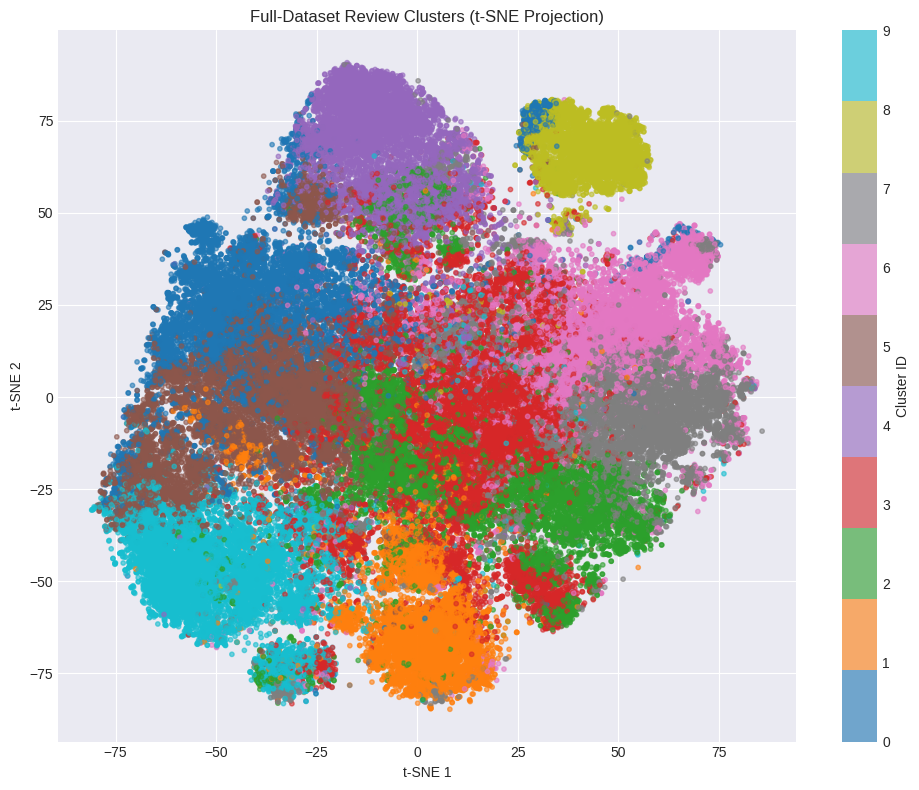

✓ Saved cluster visualization as 'review_clusters_full_tsne.png'
✓ Saved clustered dataset (with cluster_id, tsne_x, tsne_y) to 'review_clusters_full.json'


In [16]:
# -------------------------------------------------
# 4. K-Means clustering on PCA space (not t-SNE)
# -------------------------------------------------
valid_index = text_series.index
NUM_CLUSTERS = 10  # you can tune this

kmeans = KMeans(
    n_clusters=NUM_CLUSTERS,
    random_state=42,
    n_init='auto'
)
cluster_labels = kmeans.fit_predict(embeddings_pca)

# -------------------------------------------------
# 5. Build aligned dataframe with cluster info
# -------------------------------------------------
# cluster/plot the rows that had valid text
cluster_df = insights_df_clean.loc[valid_index].copy()

# Keep original row index for traceability if needed later
cluster_df["original_row_index"] = valid_index

# Attach model outputs
cluster_df["cluster_id"] = cluster_labels
cluster_df["tsne_x"] = embeddings_2d[:, 0]
cluster_df["tsne_y"] = embeddings_2d[:, 1]

print("\nCluster sizes:")
print(cluster_df["cluster_id"].value_counts().sort_index())

# -------------------------------------------------
# 6. Visualize clusters in 2D
# -------------------------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    cluster_df["tsne_x"],
    cluster_df["tsne_y"],
    c=cluster_df["cluster_id"],
    cmap="tab10",
    s=10,
    alpha=0.6
)

plt.title("Full-Dataset Review Clusters (t-SNE Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

cbar = plt.colorbar(scatter)
cbar.set_label("Cluster ID")

plt.tight_layout()
plt.savefig("review_clusters_full_tsne.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved cluster visualization as 'review_clusters_full_tsne.png'")

# -------------------------------------------------
# 7. Save clustered subset (only rows embedded)
# -------------------------------------------------
cluster_df.to_json("review_clusters_full.json", orient="records", indent=2)
print("✓ Saved clustered dataset (with cluster_id, tsne_x, tsne_y) to 'review_clusters_full.json'")

---

## **Part 7: Temporal Trend Analysis**

### **TODO 7.1**: Analyze how pain points evolved over time

**Your task**:
1. Group pain points by year
2. Track frequency of top pain points over time
3. Create line chart showing trends
4. Analyze sentiment trends over time

**Questions to answer**:
- Are customers' concerns changing over time?
- Is overall sentiment improving or declining?
- Are there seasonal patterns?

**Hints**:
- Use `insights_df.groupby('year')`
- Track top 5-10 pain points across years
- Use plotly line charts for interactivity
- Reference: M9.1 Example (Part 7)

In [12]:


# ----------------------------
# Explode pain points per year
# ----------------------------
pain_exploded = (
    insights_df_clean[['year', 'pain_points_clean']]
      .explode('pain_points_clean')
      .dropna(subset=['pain_points_clean'])
      .rename(columns={'pain_points_clean': 'pain_point'})
)

pain_counts_year = (
    pain_exploded
      .groupby(['year', 'pain_point'])
      .size()
      .reset_index(name='count')
)

# Select top N pain points overall
TOP_N = 10
top_pain_points = (
    pain_counts_year.groupby('pain_point')['count']
    .sum()
    .sort_values(ascending=False)
    .head(TOP_N)
    .index
)

pain_counts_year_top = pain_counts_year[
    pain_counts_year['pain_point'].isin(top_pain_points)
]

# ----------------------------
# Plot pain point trends
# ----------------------------
plt.figure(figsize=(10,6))

for pain_point in top_pain_points:
    subset = pain_counts_year_top[pain_counts_year_top['pain_point'] == pain_point]
    plt.plot(subset['year'], subset['count'], marker='o', label=pain_point)

plt.title("Top Pain Points Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Mentions Count")
plt.legend(title="Pain Point", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig("furniture_insight_charts/pain_point_trends.png", dpi=300)
plt.close()
print("✅ Saved: furniture_insight_charts/pain_point_trends.png")



✅ Saved: furniture_insight_charts/pain_point_trends.png


In [13]:
# ----------------------------
# Sentiment trend over time 
# ----------------------------

# Ensure sentiment column is clean
df_sent = insights_df_clean[['year', 'sentiment']].copy()
df_sent['sentiment'] = df_sent['sentiment'].fillna('neutral').str.lower()

# Count number of reviews by year and sentiment
sentiment_trend = (
    df_sent.groupby(['year', 'sentiment'])
           .size()
           .reset_index(name='count')
)

# Optional: normalize to percentages by year
sentiment_trend['percent'] = (
    sentiment_trend.groupby('year')['count']
                   .apply(lambda x: 100 * x / x.sum())
                   .values
)

# Pivot for plotting
sentiment_pivot = sentiment_trend.pivot(index='year', columns='sentiment', values='percent').fillna(0)

# ----------------------------
# Plot: Sentiment trends over time
# ----------------------------
plt.figure(figsize=(10,6))
for sentiment in sentiment_pivot.columns:
    plt.plot(
        sentiment_pivot.index,
        sentiment_pivot[sentiment],
        marker='o',
        linewidth=2,
        label=sentiment.capitalize()
    )

plt.title("Sentiment Trends Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Percentage of Reviews (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Sentiment", fontsize=10)
plt.tight_layout()

plt.savefig("furniture_insight_charts/sentiment_trend_multiline.png", dpi=300)
plt.close()

print("✅ Saved: furniture_insight_charts/sentiment_trend_multiline.png")


✅ Saved: furniture_insight_charts/sentiment_trend_multiline.png


In [14]:
# ----------------------------
# Average Sentiment Over Time
# ----------------------------

# Define sentiment encoding
sentiment_map = {
    'positive': 1,
    'mixed': 0,
    'neutral': 0,
    'negative': -1
}

# Prepare data
df_sent = insights_df_clean[['year', 'sentiment']].copy()
df_sent['sentiment'] = df_sent['sentiment'].fillna('neutral').str.lower()
df_sent['sentiment_score'] = df_sent['sentiment'].map(sentiment_map)

# Compute average sentiment per year
sentiment_by_year = (
    df_sent.groupby('year', as_index=False)['sentiment_score']
           .mean()
           .rename(columns={'sentiment_score': 'avg_sentiment_score'})
           .sort_values('year')
)

# ----------------------------
# Plot: Average sentiment trend
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(
    sentiment_by_year['year'],
    sentiment_by_year['avg_sentiment_score'],
    marker='o', color='teal', linewidth=2
)
plt.title("Average Sentiment Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Average Sentiment (-1=Negative, +1=Positive)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("furniture_insight_charts/sentiment_trend_avg.png", dpi=300)
plt.close()

print("✅ Saved: furniture_insight_charts/sentiment_trend_avg.png")


✅ Saved: furniture_insight_charts/sentiment_trend_avg.png


In [15]:
# ----------------------------
#  Positive aspect trends over time
# ----------------------------

from collections import Counter

# Ensure required columns
df_pos = insights_df_clean[['year', 'positive_aspects_clean']].copy()

# Explode aspects into individual rows
df_pos = df_pos.explode('positive_aspects_clean')

# Drop missing or empty aspects
df_pos = df_pos.dropna(subset=['positive_aspects_clean'])
df_pos = df_pos[df_pos['positive_aspects_clean'].str.strip() != '']

# Count frequency of each aspect per year
aspect_trend = (
    df_pos.groupby(['year', 'positive_aspects_clean'])
          .size()
          .reset_index(name='count')
)

# Get top N overall positive aspects (to avoid clutter)
TOP_N = 8
top_aspects = (
    df_pos['positive_aspects_clean']
    .value_counts()
    .head(TOP_N)
    .index
)

# Filter only top N aspects
aspect_trend = aspect_trend[aspect_trend['positive_aspects_clean'].isin(top_aspects)]

# Pivot for plotting
aspect_pivot = aspect_trend.pivot(index='year', columns='positive_aspects_clean', values='count').fillna(0)

# Normalize per year (optional: show % of mentions instead of raw count)
aspect_pivot = aspect_pivot.apply(lambda x: 100 * x / x.sum(), axis=1)

# ----------------------------
# Plot: Positive aspect trends over time
# ----------------------------
plt.figure(figsize=(12,7))

for aspect in aspect_pivot.columns:
    plt.plot(
        aspect_pivot.index,
        aspect_pivot[aspect],
        marker='o',
        linewidth=2,
        label=aspect.capitalize()
    )

plt.title("Trends of Positive Aspects Over Time", fontsize=15, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Mentions (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Aspect", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig("furniture_insight_charts/positive_aspect_trends.png", dpi=300)
plt.close()

print("✅ Saved: furniture_insight_charts/positive_aspect_trends.png")


✅ Saved: furniture_insight_charts/positive_aspect_trends.png


---

## **Part 8: Compare Top vs Bottom Products**

### **TODO 8.1**: Comparative analysis using LLM

**Your task**:
1. Get reviews from top 5 products (from Part 3)
2. Get reviews from bottom 5 products
3. Use LLM to identify key differences
4. Generate strategic recommendations

**Hints**:
- Sample ~50 reviews from each group
- Create a comparison prompt for the LLM
- Request structured JSON output with success/failure factors
- Reference: M9.1 Example (Part 8)

In [28]:
import json
import math
import numpy as np
import pandas as pd
from textwrap import dedent

# ----------------------------
# 1) Select top-5 & bottom-5 products
# ----------------------------
TOP_K = 5
REVIEWS_PER_SIDE = 50         # total target per group
MAX_CHARS_PER_REVIEW = 800    # truncate to control token usage

top5_titles = top10_products.sort_values("avg_rating", ascending=False)["product_title"].head(TOP_K).tolist()
bot5_titles = bottom10_products.sort_values("avg_rating", ascending=True)["product_title"].head(TOP_K).tolist()

top_df_all = df[df["product_title"].isin(top5_titles)].copy()
bot_df_all = df[df["product_title"].isin(bot5_titles)].copy()

# ----------------------------
# 2) Sample ~50 reviews per group, stratified by product
# ----------------------------
def stratified_sample_reviews(group_df, titles, total_n):
    per_product = max(1, math.floor(total_n / max(1, len(titles))))
    samples = []
    for t in titles:
        sub = group_df[group_df["product_title"] == t]
        if sub.empty:
            continue
        n = min(per_product, len(sub))
        samples.append(sub.sample(n=n, random_state=42))
    sampled = pd.concat(samples, ignore_index=True) if samples else group_df.head(0)

    # If we’re short (e.g., some products had fewer reviews), top up randomly
    shortfall = max(0, total_n - len(sampled))
    if shortfall > 0 and len(group_df) > len(sampled):
        remaining = group_df.drop(sampled.index, errors="ignore")
        if not remaining.empty:
            sampled = pd.concat([sampled, remaining.sample(n=min(shortfall, len(remaining)), random_state=43)], ignore_index=True)
    return sampled

top_sampled = stratified_sample_reviews(top_df_all, top5_titles, REVIEWS_PER_SIDE)
bot_sampled = stratified_sample_reviews(bot_df_all, bot5_titles, REVIEWS_PER_SIDE)

# Basic clean-up: pick the text field(s) you have
TEXT_COL = "review_body" if "review_body" in df.columns else "review_text" if "review_text" in df.columns else None
assert TEXT_COL is not None, "Could not find a review text column (expected 'review_body' or 'review_text')."

def prep_rows_for_prompt(df_part):
    cols = ["product_title", TEXT_COL, "star_rating", "sentiment"]
    cols = [c for c in cols if c in df_part.columns]
    # Dedup on text to avoid repeats
    tmp = df_part[cols].dropna(subset=[TEXT_COL]).drop_duplicates(subset=[TEXT_COL]).copy()
    # Truncate long reviews
    tmp[TEXT_COL] = tmp[TEXT_COL].astype(str).str.slice(0, MAX_CHARS_PER_REVIEW)
    return tmp

top_prompt_df = prep_rows_for_prompt(top_sampled)
bot_prompt_df = prep_rows_for_prompt(bot_sampled)

# ----------------------------
# 3) Build LLM comparison prompt
# ----------------------------
def build_comparison_prompt(top_df, bot_df):
    def rows_to_block(df_part, tag):
        lines = [f"{tag}:"]
        for _, r in df_part.iterrows():
            title = r.get("product_title", "")
            rating = r.get("star_rating", "")
            sent   = r.get("sentiment", "")
            text   = r.get(TEXT_COL, "")
            lines.append(dedent(f"""\
                - PRODUCT: {title}
                  RATING: {rating}
                  SENTIMENT: {sent}
                  REVIEW: {text}
            """).strip())
        return "\n".join(lines)

    header = dedent("""\
    You are a senior product insights analyst. Compare the TOP vs BOTTOM products using the sampled reviews.
    Identify *why* the top products succeed and bottom products fail.

    Return STRICT JSON ONLY with this schema:
    {
      "differentiators": ["short bullet points that clearly separate top vs bottom"],
      "success_factors": ["what top products consistently do well"],
      "failure_factors": ["what bottom products consistently do poorly"],
      "contradictions_or_edge_cases": ["optional clarifications if any"],
      "strategic_recommendations": [
        {
          "owner": "Product/Design/Ops/Marketing",
          "action": "specific change to implement",
          "priority": "P0/P1/P2",
          "expected_effect": "metric to improve (e.g., rating, returns, NPS)",
          "evidence": "brief quote or pattern reference from reviews"
        }
      ]
    }
    Keep each bullet concise (max ~20 words). Avoid repetition.
    """)

    top_block = rows_to_block(top_df, "[TOP_PRODUCTS_SAMPLE]")
    bot_block = rows_to_block(bot_df, "[BOTTOM_PRODUCTS_SAMPLE]")

    return f"{header}\n\n{top_block}\n\n{bot_block}"

comparison_prompt = build_comparison_prompt(top_prompt_df, bot_prompt_df)

# ----------------------------
# 4) Call LLM with JSON response
# ----------------------------
response_text = send_message(
    messages=[{"role": "user", "content": comparison_prompt}],
    response_format={"type": "json_object"}  # ensures valid JSON
)

# ----------------------------
# 5) Parse JSON safely
# ----------------------------
try:
    comparison_results = json.loads(response_text)
except Exception as e:
    print(f"⚠️ JSON parse error: {e}")
    comparison_results = {"raw_response": response_text}



In [ ]:
# (Optional) quick look
print(json.dumps(comparison_results, indent=2, ensure_ascii=False))

# ----------------------------
# 6) (Optional) Pretty Markdown formatter
# ----------------------------
def format_comparison_markdown(res: dict) -> str:
    parts = []
    parts.append("# Top vs Bottom Products — LLM Comparison\n")
    for key, title in [
        ("differentiators", "Differentiators"),
        ("success_factors", "Success Factors (Top)"),
        ("failure_factors", "Failure Factors (Bottom)"),
        ("contradictions_or_edge_cases", "Contradictions / Edge Cases"),
    ]:
        vals = res.get(key, [])
        if vals:
            parts.append(f"### {title}")
            for i, v in enumerate(vals, 1):
                parts.append(f"{i}. {v}")
            parts.append("")
    recs = res.get("strategic_recommendations", [])
    parts.append("### Strategic Recommendations")
    if recs:
        for i, r in enumerate(recs, 1):
            owner = r.get("owner",""); action = r.get("action","")
            prio = r.get("priority",""); effect = r.get("expected_effect","")
            evidence = r.get("evidence","")
            parts.append(f"{i}. **Owner:** {owner}")
            parts.append(f"   - Action: {action}")
            parts.append(f"   - Priority: {prio}")
            parts.append(f"   - Expected Effect: {effect}")
            parts.append(f"   - Evidence: {evidence}")
            parts.append("")
    else:
        parts.append("_No recommendations returned._\n")
    return "\n".join(parts)

#Example usage:
md = format_comparison_markdown(comparison_results)
with open("top_vs_bottom_comparison.md", "w", encoding="utf-8") as f:
    f.write(md)
print("✅ Saved: top_vs_bottom_comparison.md")


{
  "differentiators": [
    "Top products excel in aesthetics, perceived quality, and value proposition.",
    "Bottom products suffer from severe quality control issues and offensive content.",
    "Top items are praised for color vibrancy, sturdiness, and matching decor.",
    "Bottom items are described as flimsy, broken upon arrival, or morally objectionable."
  ],
  "success_factors": [
    "Vivid, beautiful, and accurate colors that match customer expectations/decor.",
    "Perceived high quality and durability relative to the price point (great value).",
    "Positive functional attributes like softness, sturdiness, or easy cleaning.",
    "Fast delivery and simple, tool-less assembly (for casters/some chairs)."
  ],
  "failure_factors": [
    "Product content is deeply offensive, promoting animal abuse themes (Dead Dog Prop).",
    "Severe structural failures: collapsing, breaking during assembly, or falling apart quickly.",
    "Critical functional defects: dehumidifiers fail

---

## **Part 9: Executive Summary**

### **TODO 9.1**: Generate executive summary using LLM

**Your task**:
1. Compile all key findings
2. Use LLM to generate business-focused executive summary
3. Include specific recommendations for market entry

**Summary should include**:
- Market opportunity assessment
- Top 3-5 key findings
- Critical success factors
- Areas to avoid
- Strategic recommendations
- Next steps for research

**Hints**:
- Provide LLM with aggregated data (top pain points, positives, etc.)
- Request structured JSON output
- Focus on actionable insights
- Reference: M9.1 Example (Part 9)

In [30]:
import json
from textwrap import dedent
import datetime

def generate_executive_summary(insights_df_clean, pain_counts, positive_counts, comparison=None):
    """
    Generate an executive summary using LLM via OpenRouter.
    Includes market opportunity, key findings, and strategic recommendations.
    """
    # -----------------------------
    # 1️⃣ Aggregate and prepare summary data
    # -----------------------------
    summary_data = {
        "total_reviews": len(insights_df_clean),
        "avg_star_rating": round(insights_df_clean["star_rating"].mean(), 2),
        "top_pain_points": [item for item, _ in pain_counts.most_common(20)],
        "top_positive_aspects": [item for item, _ in positive_counts.most_common(20)],
        "comparison_summary": comparison if comparison else "Comparison insights unavailable.",
    }

    # -----------------------------
    # 2️⃣ Build LLM prompt
    # -----------------------------
    prompt = dedent(f"""
    You are a senior business strategy analyst.
    Based on the aggregated customer insights below, create an EXECUTIVE SUMMARY
    suitable for senior management evaluating a potential market entry.

    Data summary:
    {json.dumps(summary_data, indent=2, ensure_ascii=False)}

    Your summary must be concise and actionable.

    Return STRICT JSON ONLY with this structure:
    {{
      "market_opportunity": "Brief analysis of potential and target segment",
      "key_findings": ["Top 3-5 insights based on data"],
      "critical_success_factors": ["What must be done well to succeed"],
      "areas_to_avoid": ["Pitfalls or market segments to avoid"],
      "strategic_recommendations": [
          {{
              "owner": "Product/Design/Ops/Marketing",
              "action": "Specific step or initiative",
              "priority": "P0/P1/P2",
              "expected_effect": "Metric expected to improve",
              "evidence": "Grounded in pain/positive patterns"
          }}
      ],
      "next_steps_for_research": ["Further analysis or validation studies required"]
    }}
    """)

    # -----------------------------
    # 3️⃣ Send message to LLM
    # -----------------------------
    response_text = send_message(
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"}  # ensures model outputs valid JSON
    )

    # -----------------------------
    # 4️⃣ Parse JSON response safely
    # -----------------------------
    try:
        result = json.loads(response_text)
    except Exception as e:
        print(f"⚠️ JSON parsing failed: {e}")
        result = {"raw_response": response_text}

    return result






# -----------------------------
# 5️⃣ Generate and Save JSON
# -----------------------------
exec_summary = generate_executive_summary(insights_df_clean, pain_counts, positive_counts, comparison_results)

# Define output directory & filename
os.makedirs("reports", exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
json_path = f"executive_summary_{timestamp}.json"

# Save the JSON output
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(exec_summary, f, indent=2, ensure_ascii=False)

print(f"✅ Executive summary saved to: {json_path}")

✅ Executive summary saved to: executive_summary_2025-11-02_21-21.json


### **TODO 9.2**: Display and save executive summary

**Your task**: Format and display the executive summary clearly.

**Hints**:
- Print each section with clear headers
- Use numbered lists for findings and recommendations
- Save to a separate text file or markdown file for reporting

In [31]:

import os
import datetime
from textwrap import fill

def _as_list(x):
    if x is None:
        return []
    return x if isinstance(x, list) else [x]

def _safe(s):
    return "" if s is None else str(s)

def render_exec_summary_markdown(summary: dict, width=100) -> str:
    """
    Generate a formatted **Markdown** version of the executive summary.
    - Adds Markdown headings (#, ###)
    - Keeps structured indentation and numbered lists
    - Suitable for saving to a .md report
    """
    # Safely extract and normalize all fields from the summary dictionary
    market   = _safe(summary.get("market_opportunity"))
    findings = _as_list(summary.get("key_findings"))
    csf      = _as_list(summary.get("critical_success_factors"))
    avoid    = _as_list(summary.get("areas_to_avoid"))
    recs     = _as_list(summary.get("strategic_recommendations"))
    nexts    = _as_list(summary.get("next_steps_for_research"))

    lines = []
    lines.append("# Executive Summary\n")  # Main heading

    # --- Market Opportunity Section ---
    if market:
        lines.append("### Market Opportunity")
        lines.append(fill(market, width=width))  # wrap text neatly
        lines.append("")

    # --- Key Findings Section ---
    if findings:
        lines.append("### Key Findings")
        for i, item in enumerate(findings, 1):
            lines.append(f"{i}. {item}")
        lines.append("")

    # --- Critical Success Factors Section ---
    if csf:
        lines.append("### Critical Success Factors")
        for i, item in enumerate(csf, 1):
            lines.append(f"{i}. {item}")
        lines.append("")

    # --- Areas to Avoid Section ---
    if avoid:
        lines.append("### Areas to Avoid")
        for i, item in enumerate(avoid, 1):
            lines.append(f"{i}. {item}")
        lines.append("")

    # --- Strategic Recommendations Section ---
    lines.append("### Strategic Recommendations")
    if recs:
        for i, r in enumerate(recs, 1):
            # handle structured dictionary or plain string entries
            if isinstance(r, dict):
                lines.append(f"{i}. **Owner:** {r.get('owner','')}")
                lines.append(f"   - Action: {r.get('action','')}")
                lines.append(f"   - Priority: {r.get('priority','')}")
                lines.append(f"   - Expected Effect: {r.get('expected_effect','')}")
                lines.append(f"   - Evidence: {r.get('evidence','')}")
            else:
                lines.append(f"{i}. {r}")
        lines.append("")
    else:
        lines.append("_No recommendations provided._\n")

    # --- Next Steps for Research Section ---
    if nexts:
        lines.append("### Next Steps for Research")
        for i, item in enumerate(nexts, 1):
            lines.append(f"{i}. {item}")
        lines.append("")

    # Join all lines into a single Markdown-formatted string
    return "\n".join(lines).strip() + "\n"


def render_exec_summary_plain(summary: dict, width=100) -> str:
    """
    Generate a **plain text** version of the executive summary.
    - No Markdown symbols
    - Cleanly indented and readable in console or logs
    """
    # Safely extract all fields (convert lists/None to readable form)
    market   = _safe(summary.get("market_opportunity"))
    findings = _as_list(summary.get("key_findings"))
    csf      = _as_list(summary.get("critical_success_factors"))
    avoid    = _as_list(summary.get("areas_to_avoid"))
    recs     = _as_list(summary.get("strategic_recommendations"))
    nexts    = _as_list(summary.get("next_steps_for_research"))

    lines = []
    lines.append("EXECUTIVE SUMMARY\n")  # Main heading (plain text)

    # --- Market Opportunity Section ---
    if market:
        lines.append("Market Opportunity:")
        lines.append(fill(market, width=width))
        lines.append("")

    # --- Key Findings Section ---
    if findings:
        lines.append("Key Findings:")
        for i, item in enumerate(findings, 1):
            lines.append(f"  {i}. {item}")
        lines.append("")

    # --- Critical Success Factors Section ---
    if csf:
        lines.append("Critical Success Factors:")
        for i, item in enumerate(csf, 1):
            lines.append(f"  {i}. {item}")
        lines.append("")

    # --- Areas to Avoid Section ---
    if avoid:
        lines.append("Areas to Avoid:")
        for i, item in enumerate(avoid, 1):
            lines.append(f"  {i}. {item}")
        lines.append("")

    # --- Strategic Recommendations Section ---
    lines.append("Strategic Recommendations:")
    if recs:
        for i, r in enumerate(recs, 1):
            # handle structured dict or plain string recommendations
            if isinstance(r, dict):
                lines.append(f"  {i}. Owner: {r.get('owner','')}")
                lines.append(f"     - Action: {r.get('action','')}")
                lines.append(f"     - Priority: {r.get('priority','')}")
                lines.append(f"     - Expected Effect: {r.get('expected_effect','')}")
                lines.append(f"     - Evidence: {r.get('evidence','')}")
            else:
                lines.append(f"  {i}. {r}")
        lines.append("")
    else:
        lines.append("  No recommendations provided.\n")

    # --- Next Steps for Research Section ---
    if nexts:
        lines.append("Next Steps for Research:")
        for i, item in enumerate(nexts, 1):
            lines.append(f"  {i}. {item}")
        lines.append("")

    # Join all lines into a single plain-text string
    return "\n".join(lines).strip() + "\n"



def save_and_print_exec_summary(summary: dict, base_name="executive_summary"):
    """Print in plain text, save Markdown file."""
    ts = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    md_path = f"{base_name}_{ts}.md"

    markdown_text = render_exec_summary_markdown(summary)
    plain_text = render_exec_summary_plain(summary)

    # Print in plain text (for readability in notebook)
    print("\n==============================")
    print("📊 EXECUTIVE SUMMARY")
    print("==============================\n")
    print(plain_text)

    # Save markdown quietly
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(markdown_text)

    print(f"\n✅ Executive summary saved to: {os.path.abspath(md_path)}")



In [32]:
exec_summary = generate_executive_summary(insights_df_clean, pain_counts, positive_counts, comparison_results)
save_and_print_exec_summary(exec_summary)


📊 EXECUTIVE SUMMARY

EXECUTIVE SUMMARY

Market Opportunity:
The market shows strong demand for products delivering high aesthetic appeal, perceived quality, and
value. Success hinges on flawless execution regarding material integrity and accurate product
representation, as customer tolerance for quality failures is low despite a generally positive
average rating (3.99/5.0).

Key Findings:
  1. Quality Control is the primary driver of negative sentiment, evidenced by frequent complaints regarding 'arrived damaged,' 'missing parts,' and 'poor construction.'
  2. Aesthetics and perceived value are major differentiators; products praised for 'looks great,' 'solid wood,' and 'looks expensive' drive positive reviews.
  3. Assembly experience is polarized: while some praise 'easy assembly,' many struggle with 'difficult assembly' and 'poor instructions,' suggesting inconsistency in documentation or design.
  4. Critical product failures cluster around specific items (e.g., one-year dehumidif

---

## **Submission Checklist**

Before submitting, ensure you have:

### **Files**
- [ ] This completed Jupyter notebook
- [ ] Saved insights JSON file (`YOUR_CATEGORY_review_insights.json`)
- [ ] Comprehensive results JSON file
- [ ] Generated visualization images (PNG files)

### **Analysis Components**
- [ ] Loaded and explored your chosen dataset
- [ ] Implemented parallel LLM processing
- [ ] Extracted structured insights (pain points, positives, themes)
- [ ] Aggregated and counted frequencies
- [ ] Created visualizations
- [ ] Analyzed by rating categories
- [ ] Performed temporal analysis
- [ ] Compared top vs bottom products
- [ ] Generated executive summary with recommendations

### **Code Quality**
- [ ] All cells run without errors
- [ ] Comments explain key decisions
- [ ] Outputs are clearly labeled
- [ ] Visualizations are properly formatted
- [ ] Results are interpreted with business context

### **Documentation**
- [ ] Markdown cells explain your approach
- [ ] Key findings are highlighted
- [ ] Executive summary is clear and actionable
- [ ] Limitations and future work are discussed

---

## **Resources and References**

### **Course Materials**
- **M7.1**: Embedding generation and vector search
- **M7.3**: Parallel query processing examples
- **M8.1**: Agentic RAG, async helpers, tool use
- **M9.1**: Async/parallel processing example
- **M9.2**: Clustering embedding vectors example

---

## **Tips for Success**

1. **Start early**: LLM processing takes time even with parallelization
2. **Test with small samples first**: Verify your code works before processing thousands of reviews
3. **Monitor API costs**: Check OpenRouter dashboard periodically
4. **Save frequently**: Use checkpoints to avoid losing progress
5. **Focus on insights**: Don't just report numbers, explain what they mean for the business
6. **Be specific in prompts**: Clear, detailed prompts get better LLM responses
7. **Validate results**: Spot-check LLM outputs to ensure quality
8. **Think critically**: Does the analysis make sense? Are there surprising patterns?

---

## **Good luck with your project!**